In [1]:
import cv2 
from matplotlib import pyplot as plt

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame_v2 import FLCDataset, visualize_transformed_image


In [3]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc\train.csv", r"C:\Users\lucyc\Desktop\face_loc\train")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc\val.csv", r"C:\Users\lucyc\Desktop\face_loc\val")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc\test.csv", r"C:\Users\lucyc\Desktop\face_loc\test")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [4]:
a, b, c = next(iter(val_loader))

In [5]:
a.shape

torch.Size([32, 3, 12, 12])

In [6]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [7]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [9]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 12, 3)  #24 -> 22 -> maxp -> 11
        self.conv2 = nn.Conv2d(12, 24, 3) #11 -> 9
        self.conv3 = nn.Conv2d(24, 32, 3) #9 -> 7

        self.face_det = nn.Conv2d(32, 2, 3) #1 -> 1
        self.bbox = nn.Conv2d(32, 4, 3) #1 -> 1
        self.landmark = nn.Conv2d(32, 10, 3) #1 -> 1

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #10
        x = F.max_pool2d(x, 2) #5
        x = F.relu(self.conv2(x)) #3
        x = F.relu(self.conv3(x)) #1

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        facedet = torch.flatten(facedet, 1)
        bbox = torch.flatten(bbox, 1)
        landmark = torch.flatten(landmark, 1)

        return facedet, bbox, landmark


In [15]:
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype == "2":
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "3":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0.5 * landmark_loss + facedet_loss)

        #loss_total = loss_total / len(ltypes)
        loss_total = loss_total
        
        return loss_total

In [16]:
class PNetLossFace(nn.Module):
    def __init__(self):
        super(PNetLossFace, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype == "2":
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0 * bbox_loss + facedet_loss)

            elif ltype == "3":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0 * landmark_loss + facedet_loss)

        #loss_total = loss_total / len(ltypes)
        loss_total = loss_total
        
        return loss_total

In [28]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [29]:
model.train()  # 设置模型为训练模式

train_x = []
train_loss_y = []

train_loss_acc = 0.
train_num = 0

for inputs in train_loader:
    
    img_tensor = inputs[0].to(device)
    label = inputs[1].to(device)
    ltypes = inputs[2]

    facedet, bbox, landmark = model(img_tensor)
    optimizer.zero_grad()  # 清除之前的梯度
    loss = criterion(facedet, bbox, landmark, label, ltypes)
    # 反向传播和优化
    loss.backward()  # 反向传播计算当前的梯度
    optimizer.step()  # 更新参数

    train_loss_acc += loss.item()
    train_num += 1

    train_x.append(train_num)
    train_loss_y.append(loss.item())
    
    print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))
    

1 455.36614990234375 2.276830749511719 32 130000
2 685.7841796875 5.705751647949219 64 130000
3 632.2738037109375 8.867120666503906 96 130000
4 522.7780151367188 11.4810107421875 128 130000
5 793.8626708984375 15.450324096679687 160 130000
6 706.024169921875 18.98044494628906 192 130000
7 575.6019897460938 21.85845489501953 224 130000
8 606.8617553710938 24.892763671875 256 130000
9 518.7615356445312 27.486571350097655 288 130000
10 687.9966430664062 30.926554565429687 320 130000
11 620.490966796875 34.029009399414065 352 130000
12 623.7739868164062 37.14787933349609 384 130000
13 533.6079711914062 39.815919189453126 416 130000
14 639.6251220703125 43.01404479980469 448 130000
15 674.6126098632812 46.387107849121094 480 130000
16 601.7403564453125 49.39580963134765 512 130000
17 754.6295776367188 53.16895751953125 544 130000
18 704.1731567382812 56.68982330322265 576 130000
19 612.0700073242188 59.75017333984375 608 130000
20 717.5137329101562 63.33774200439453 640 130000
21 665.465942

In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [36]:

criterion = PNetLossFace()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 11.810450553894043 11.810450553894043 32 19999
2 8.485125541687012 10.147788047790527 64 19999
3 14.213567733764648 11.503047943115234 96 19999
4 17.437524795532227 12.986667156219482 128 19999
5 10.059578895568848 12.401249504089355 160 19999
6 7.284038066864014 11.548380931218466 192 19999
7 11.467133522033691 11.536774158477783 224 19999
8 12.86513614654541 11.702819406986237 256 19999
9 19.413911819458008 12.559607452816433 288 19999
10 8.127971649169922 12.116443872451782 320 19999
11 9.691750526428223 11.896017204631459 352 19999
12 15.598005294799805 12.204516212145487 384 19999
13 15.476506233215332 12.456207752227783 416 19999
14 14.328073501586914 12.589912448610578 448 19999
15 9.513144493103027 12.384794584910075 480 19999
16 15.459992408752441 12.576994448900223 512 19999
17 20.73178482055664 13.05668800017413 544 19999
18 6.025935649871826 12.666090647379557 576 19999
19 9.241128921508789 12.485829503912674 608 19999
20 19.183584213256836 12.820717239379883 640 19999
21

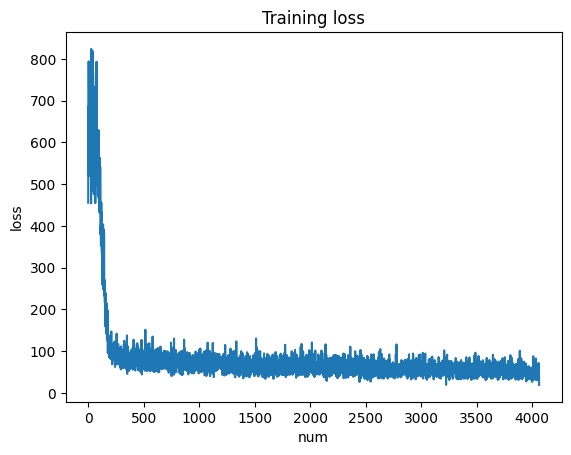

In [35]:
# draw loss curve
plt.plot(train_x, train_loss_y, label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [32]:
# 保存模型
torch.save(model, 'face_loc_p_NN.pth')

In [111]:
# load model
model_trained = torch.load('face_loc_p_1.pth')
model_trained.eval()  # 设置模型为评估/测试模式


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [115]:
aa = iter(test_loader)

In [118]:

a, b, c = next(aa)

In [119]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "half face"
    if i == "2":
        return "not face"
    if i == "3":
        return "face"

In [ ]:
for i in range(32):
    visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    print(is_face(c[i]))
    face_det, bbox, landmark = model_trained(a[i].to(device))
    if face_det[0] > face_det[1]:
        print("face")
        visualize_transformed_image(a[i],get_argsn(bbox),get_argsn(landmark))   
    else:
        print("not face")
        visualize_transformed_image(a[i],[0,0,0,0],None)

In [ ]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))

    model.eval() 
    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(train_dataset))

    print("Epoch [{}/{}], Loss: {:.2f}, Val_loss: {:.2f}".format(epoch+1, num_epochs, val_loss_acc/val_num, val_loss_acc/val_num))

    # draw loss curve
    plt.plot(train_x, train_loss_y, label='train')
    plt.xlabel('num')
    plt.ylabel('loss')
    plt.title('Training loss')
    plt.show()
    
    input("Press Enter to continue...")
